In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
from keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split

In [ ]:
base_path = '/content/drive/MyDrive/DB_Angiograms_134/Database_134_Angiograms'
sample_img_path = os.path.join(base_path, '100_gt.pgm')

# Load a sample image
sample_img = load_img(sample_img_path, color_mode='grayscale')

# Print the size of the sample image
print(f'Sample image size: {sample_img.size}')

Sample image size: (300, 300)


In [ ]:
base_path = '/content/drive/MyDrive/DB_Angiograms_134/Database_134_Angiograms'
img_height, img_width = 300,300

def load_images_and_masks(base_path, img_height, img_width):
    images = []
    masks = []

    for i in range(1, 135):
        img_path = os.path.join(base_path, f'{i}.pgm')
        mask_path = os.path.join(base_path, f'{i}_gt.pgm')

        img = load_img(img_path, color_mode='grayscale', target_size=(img_height, img_width))
        mask = load_img(mask_path, color_mode='grayscale', target_size=(img_height, img_width))

        img = img_to_array(img)/255
        mask = img_to_array(mask)/255

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load the images and masks
X, y = load_images_and_masks(base_path, img_height, img_width)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D
from keras.models import Model

def unet(input_shape):
    inputs = Input(input_shape)  # Input shape: (300, 300, 1)

    # Contracting Path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # Output shape: (300, 300, 64)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)  # Output shape: (300, 300, 64)
    pool1 = MaxPooling2D((2, 2))(conv1)  # Output shape: (150, 150, 64)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)  # Output shape: (150, 150, 128)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)  # Output shape: (150, 150, 128)
    pool2 = MaxPooling2D((2, 2))(conv2)  # Output shape: (75, 75, 128)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)  # Output shape: (75, 75, 256)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)  # Output shape: (75, 75, 256)
    pool3 = MaxPooling2D((2, 2))(conv3)  # Output shape: (37, 37, 256)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)  # Output shape: (37, 37, 512)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)  # Output shape: (37, 37, 512)
    pool4 = MaxPooling2D((2, 2))(conv4)  # Output shape: (18, 18, 512)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)  # Output shape: (18, 18, 1024)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)  # Output shape: (18, 18, 1024)

    # Expansive Path
    up6 = UpSampling2D((2, 2))(conv5)  # Output shape: (36, 36, 1024)
    up6 = tf.image.resize(up6, [tf.shape(conv4)[1], tf.shape(conv4)[2]], method='bilinear')
    up6 = concatenate([up6, conv4], axis=-1)  # Output shape: (36, 36, 1536)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)  # Output shape: (36, 36, 512)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)  # Output shape: (36, 36, 512)

    up7 = UpSampling2D((2, 2))(conv6)  # Output shape: (72, 72, 512)
    up7 = tf.image.resize(up7, [tf.shape(conv3)[1], tf.shape(conv3)[2]], method='bilinear')
    up7 = concatenate([up7, conv3], axis=-1)  # Output shape: (72, 72, 768)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)  # Output shape: (72, 72, 256)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)  # Output shape: (72, 72, 256)

    up8 = UpSampling2D((2, 2))(conv7)  # Output shape: (144, 144, 256)
    up8 = tf.image.resize(up8, [tf.shape(conv2)[1], tf.shape(conv2)[2]], method='bilinear')
    up8 = concatenate([up8, conv2], axis=-1)  # Output shape: (144, 144, 384)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)  # Output shape: (144, 144, 128)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)  # Output shape: (144, 144, 128)

    up9 = UpSampling2D((2, 2))(conv8)  # Output shape: (288, 288, 128)
    up9 = tf.image.resize(up9, [tf.shape(conv1)[1], tf.shape(conv1)[2]], method='bilinear')
    up9 = concatenate([up9, conv1], axis=-1)  # Output shape: (288, 288, 128)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)  # Output shape: (288, 288, 64)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)  # Output shape: (288, 288, 64)

    # Final Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)  # Output shape: (300, 300, 1)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Define the input shape and create the model
input_shape = (300, 300, 1)
model = unet(input_shape)

# Print the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300, 300, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 300, 300, 64)         640       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 300, 300, 64)         36928     ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 150, 150, 64)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2 * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

# Combined loss
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)  # Add the missing closing parenthesis here
    return bce + d_loss  # Adjust the weighting as needed

model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=8,
    validation_data=(X_val, y_val)
)

Epoch 1/80
14/14 [==============================] - 16s 803ms/step - loss: 8.6447 - accuracy: 0.9443 - val_loss: 1.1567 - val_accuracy: 0.9494
Epoch 2/80
14/14 [==============================] - 11s 767ms/step - loss: 1.1480 - accuracy: 0.9445 - val_loss: 1.1247 - val_accuracy: 0.9494
Epoch 3/80
14/14 [==============================] - 11s 766ms/step - loss: 1.1316 - accuracy: 0.9445 - val_loss: 1.1298 - val_accuracy: 0.9494
Epoch 4/80
14/14 [==============================] - 11s 769ms/step - loss: 1.1313 - accuracy: 0.9445 - val_loss: 1.1099 - val_accuracy: 0.9494
Epoch 5/80
14/14 [==============================] - 10s 743ms/step - loss: 1.0964 - accuracy: 0.9445 - val_loss: 1.1239 - val_accuracy: 0.9494
Epoch 6/80
14/14 [==============================] - 11s 754ms/step - loss: 1.0934 - accuracy: 0.9445 - val_loss: 1.0692 - val_accuracy: 0.9494
Epoch 7/80
14/14 [==============================] - 11s 803ms/step - loss: 1.0768 - accuracy: 0.9445 - val_loss: 1.0858 - val_accuracy: 0.9494

In [ ]:
sample_img = load_img('/content/2.png', color_mode='grayscale')
sample_img.size

(512, 512)

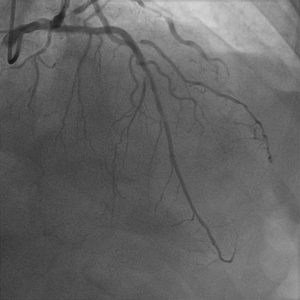

In [ ]:
sample_img.resize((300, 300))

In [ ]:
from PIL import Image # Import the Image module

# ... (Your existing encoder_block, decoder_block, dense_block functions remain the same)

def preprocess_image(image_path):
  img = Image.open(image_path).convert('L')  # Open as grayscale and convert to single channel
  img = img.resize((300, 300))  # Resize to 300x300
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
  img_array = tf.expand_dims(img_array, axis=0) # Add batch dimension
  return img_array

# Assuming 'image_path' is the path to your 512x512 image
preprocessed_image = preprocess_image('/content/2.png')
prediction = model.predict(preprocessed_image)

1/1 [==============================] - 0s 20ms/step


In [ ]:
prediction.shape

(1, 300, 300, 1)

In [ ]:
predicted_image_array = prediction[0]  # Remove batch dimension
predicted_image_array = predicted_image_array.squeeze() # Remove the single channel dimension
predicted_image_array = predicted_image_array*255  # Scale back to [0, 255]
predicted_image_array = predicted_image_array.astype(np.uint8)  # Convert to 8-bit integer
predicted_image = Image.fromarray(predicted_image_array, mode='L')  # Create image from array
predicted_image.show()  # Display the image

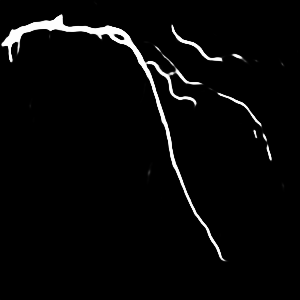

In [ ]:
predicted_image